# Infectious disease modelling

Models of diseases are tools used by epidemiologists, public health experts, and mathematicians to understand, predict, and control the spread of infectious diseases within populations. These models use mathematical equations and/or statistical representations of various aspects of disease transmission, such as the rate of infection, recovery, and death. 

## Types of disease models: overview

```{margin}
In some literature, ABMs are also called IBMs, for *individual-based models*. 
```
The range fo common models spands between deterministic and stochatisc models; they can be expressed as compartmental models ("fully mechanistic"), semi-mechanistic or agent-based models (ABMs); they can be purely temporal or spatial, or network models. 

**Compartmental (mechanistics) models** subdivide the population into different compartments based on disease status. The prototypical compartmental model is the SIR model, which divides the population into three compartments: Susceptible (S), Infected (I), and Recovered (R). Extensions of this model include the SEIR model (which includes an Exposed compartment) and the SIRS model (which allows individuals to become susceptible again after recovery) and other.

**Semi-mechanistic models** incorporate both empirical data and simplified mechanistic components to simulate disease transmission, whereas mechanistic models solely rely on detailed understanding of biological and epidemiological processes to describe disease dynamics without incorporating empirical data.

**Agent-Based Models (ABMs)** simulate the actions and interactions of individuals within a population. Each individual (or agent) is represented separately and can have unique characteristics and behaviors. ABMs are useful for studying complex systems and behaviors that cannot be captured by compartmental models, such as individual-level heterogeneity and spatial dynamics.

**Network Models** represent the population as a network of interconnected nodes, with each node representing an individual and edges representing contacts between individuals. These models are particularly useful for studying diseases that spread through social networks, such as sexually transmitted infections or airborne diseases in close-knit communities.

**Stochastic Models** incorporate randomness into the modeling process. Unlike deterministic models, which produce exact predictions based on fixed parameters, stochastic models account for probabilistic events such as chance encounters between individuals and random variations in disease transmission. Stochastic models are particularly useful for studying small populations or rare events.

These are just a few examples of the many mathematical models used to study disease transmission. Each type of model has its own strengths and limitations, and the choice of model depends on the specific characteristics of the disease being studied and the questions being addressed by researchers.

## Outbreak modelling

In this lecture, we will explore modeling options for studying outbreaks.

A mathematical model is a mathematical representation of a system, that can be used to explore its behaviour. The goals of *real-time* infectious disease modelling is to 

- Look at data from an outbreak so far, 
- Construct a model that represents the underlying epidemiology of the system, 
- Perform simulations of the model *forward* to *predict* what might likely happen in the future (how many cases are we expecting to see per day?), 
- Introduce *control interventions* into the model to look at how different control intervention might effect the outcomes we would like to see in the future.

## Key questions

The two key questions here are

1). How do we build a mathematical model of an outbreak?

In this lecture we will investigate the following quetsions:

- Is there a characteristic "shpae" of an infectious idsease outbreak?
- Building a simple infectious disease outbreak model,
- What is the basic reproduction number $R_0$ and how is it used,
- Extensions of the simple model.

2). How can models be used to inform public health measures at *different stages* of an outbreak?

- Early in an outbreak
- When a major outbreak is ongoing
- End of an outbreak

### Boarding school data

This dataset contains records of an outbreak of influenza A (H1N1) in 1978 at a British boarding school. The data consists of the daily number of students in bed (prevalence data), spanning over a time interval of 14 days. 

There were 763 male students who were mostly full boarders and 512 of them became ill. The outbreak lasted from the 22nd of January to the 4th of February. It is reported that one infected boy started the epidemic, which spread rapidly in the relatively closed community of the boarding school. The data are freely available in the R package `outbreaks`, maintained as part of the [R Epidemics Consortium](https://www.repidemicsconsortium.org/), and is a great resource for trying to fit different models yourself after the course.

In [2]:
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Specify the path to CSV file woth data
csv_file = "data/influenza_england_1978_school.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(csv_file)

# Rename the 'Unnamed: 0' column to 't'
data = data.rename(columns={'Unnamed: 0': 't'})

data.head()

,t,date,in_bed,convalescent
0,1,1978-01-22,3,0
1,2,1978-01-23,8,0
2,3,1978-01-24,26,0
3,4,1978-01-25,76,0
4,5,1978-01-26,225,9


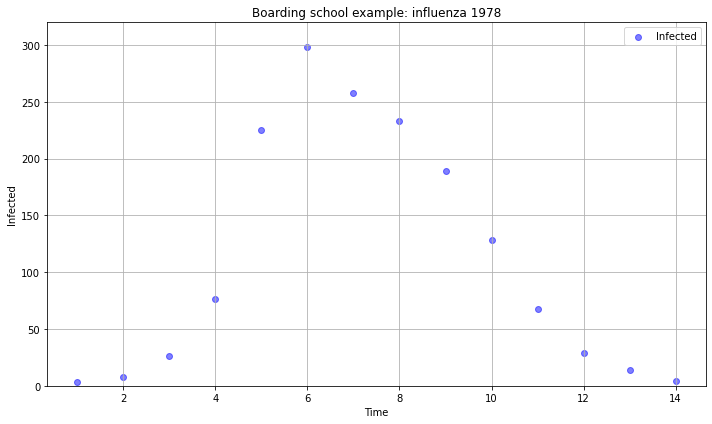

In [4]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot 'in_bed' against 'date'
plt.scatter(data['t'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# Set the labels and title
plt.xlabel('Time')
plt.ylabel('Infected')
plt.ylim(0, 320)
plt.title('Boarding school example: influenza 1978')

# Show the plot
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()




### The "shape"

Most *single-wave* infectious disease outbreaks tend to have a characteristic shape: at the start, the number of infected individuals increases, reaches its peaks, and then goes down back to near zero.


### A simple mathematical model: exponential growth

We would like to recreate that shape using a mathematical model.

The simplest possible assumption about how a disease spreads is that each case of disease leads on to some fixed number of new cases every day. 

```{tikz}  
  [level distance=20mm,level/.style={sibling distance=40mm/#1}]
  \node[circle, draw, fill=red!30] {D0}
    child {node[circle, draw, fill=red!30] {D1}
      child {node[circle, draw, fill=red!30] {D2}}
      child {node[circle, draw, fill=red!30] {D2}}
    }
    child {node[circle, draw, fill=red!30] {D1}
      child {node[circle, draw, fill=red!30] {D2}}
      child {node[circle, draw, fill=red!30] {D2}}
    };
```

Day 0: 1 

Day 1: 2

Day 2: 4=2^2

Day 3: 8=3^2

```{margin}
Verify the formula for geomtric progression. What is the total number of infections by day $T$?
```
This model is a *geometric progression*. According to it, every day the number of new cases is

$$
I_t = 2^t
$$

Would this model look like any real data?

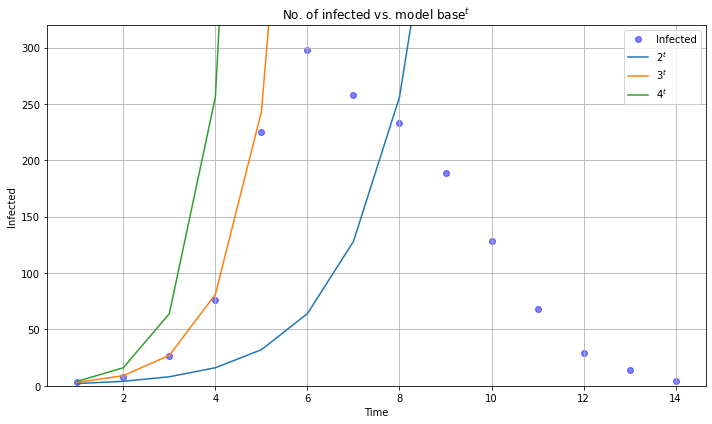

In [5]:
# Function to calculate exponential function for a given base
def exponential_function(t, base):
    return base**t

# Base values for plotting
base_values = [2, 3, 4]


# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot 'in_bed' against 't'
plt.scatter(data['t'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# Plot exponential functions for different base values
for base in base_values:
    y_values = exponential_function(data['t'], base)
    plt.plot(data['t'], y_values, label=f'${base}^t$')

# Set the labels and title
plt.xlabel('Time')
plt.ylabel('Infected')
plt.ylim(0, 320)
plt.title('No. of infected vs. model base$^t$')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

What happens if we compare this model to the real data? 

We can see that for some values of `base` the curve fits observed data well (`base=3`), but only at the very start of the outbreak. Hence, exponential growth can be used to described early stages of an outbreak.

The rest of the fit is not convincing. We need to find a better model.

## Compartmental modelling

As the next step, we need to refine the model and make sure that the model matches the data more closely.

While building this model, we have missed out on *disease biology*! For example, the fact that diseases gradually run out of susceptible (uninfected) individuals to infect.

What we can do instead, is what is called *compartmental modelling*.

The main idea behind compartmenta models, is that they don't just keep track of many individuals were infected, but they also keep track of all the individuals with various infection and symptom statuses.

### The SI model

The Susceptible-Infected (SI) model is one of the simplest compartmental models used to describe the spread of infectious diseases within a population. In the SI model, individuals move from the susceptible (`S`) to the infected (`I`) state, but there is no recovery or immunity acquired. 

The *infection rate* $\beta$ quantifies how quickly individuals move from compartment `S` transition compartment `I`.

Here are the basic formulas for the SI model:



Let:

- $S(t)$ be the number of susceptible individuals at time $t$. 
- $I(t)$ be the number of infected individuals at time $t$.
- $N$ be the total population size (constant over time).

```{tikz}
% Nodes
\node[draw, circle, fill=blue!30] (S) at (0,0) {S};
\node[draw, circle, fill=red!30] (I) at (2,0) {I};
    
% Arrows
\draw[->, thick] (S) to[out=45,in=135] node[midway, above]{$\beta S I/N$} (I);
```

The dynamics of the SI model can be described using a set of ODEs. One of them describes the rate of change in susceptiopal individuals $\frac{dS}{dt}$ and the other one describes the rate of change in infected individuals $\frac{dI}{dt}$:

```{margin}
Sometimes these models are written in terms of `i(t) = I(t)/N` and `s(t) = S(t)/N`.
```

$$
\begin{align*}
\frac{dS}{dt} &= - \beta S I/N, \\
\frac{dI}{dt} &= \beta S I/N.
\end{align*}
$$

Here

$$
N = S+I
$$

is the total population size which is assumed to be constant.

The number of susceptible individuals decreaases over time, and the number of infected individuals increases over time, as infections happen.

Note that the rate $\beta S\frac{I}{N}$ is proportinal both to the number of infected and suscepted individuals. If there is a large number of succeptible individuals, then there is a lot of people who are a target for the disease, i.e. people who the disease could infect. Similarly, id there is a lot of infected individuals, there's many individuals who can do the infecting. 

### The SI model in Numpyro

Let us implement the SI model in Numpyro and apply it to the boarding school data.


In [42]:
def SI(observed_data, z_init=None, n_states=2):
    """
    Susceptible-Infectious (SI) model.

    beta: Infection rate (transmission rate).

    S, I :    Arrays representing the number of susceptible and infected individuals
              at each time step.
    """

    def dz_dt(z, t):
        S = z[0]
        I = z[1]

        N = 763  # hardcode N!!! -> change this in the future
        dS_dt = -beta * I * S / N
        dI_dt =  beta * I * S / N 

        return jnp.stack([dS_dt, dI_dt])

    if z_init is None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))
    
    # Define prior for beta
    beta = numpyro.sample('beta',dist.TruncatedNormal(loc=2, scale=1, low=0.))

    # integrate dz/dt, the result will have shape num_days x 2
    time = jnp.arange(len(observed_data))*1.0
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, time, rtol=1e-6, atol=1e-5, mxstep=1000))

    # Likelihood
    obs = numpyro.sample("observed", dist.Poisson(z[:, 1]), obs=observed_data)

# observed data
observed_data = jnp.array(data['in_bed'])

# Run MCMC
nuts_kernel = NUTS(SI)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, progress_bar=False)
mcmc.run(jax.random.PRNGKey(0), jnp.array(data['in_bed']))


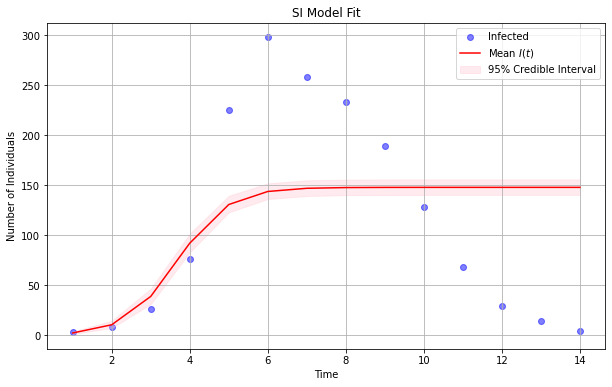

In [40]:
# Extract posterior samples
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples['z']

# Calculate median and credible intervals
lower_bound_infected = jnp.percentile(z_samples, 2.5, axis=0)[:, 1]
upper_bound_infected = jnp.percentile(z_samples, 97.5, axis=0)[:, 1]
mean_infected        = jnp.mean(z_samples, axis=0)[:, 1]

# Plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(data['t'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# Plot median of the posterior distribution
plt.plot(data['t'], mean_infected, color='red', label='Mean $I(t)$')

# Plot uncertainty bounds
plt.fill_between(data['t'], lower_bound_infected, upper_bound_infected, color='pink', alpha=0.3, label='95% Credible Interval')

plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('SI Model Fit')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


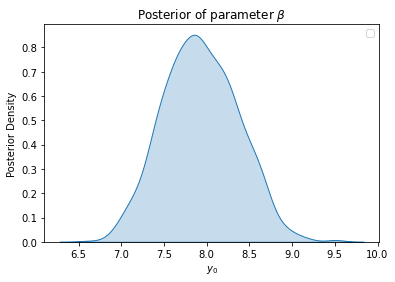

In [41]:
# Extract posterior samples
plt.figure(figsize=(6, 4))
sns.kdeplot(posterior_samples['beta'], fill=True)
plt.xlabel('$y_0$')
plt.ylabel('Posterior Density')
plt.title(r'Posterior of parameter $\beta$')
plt.legend()

# Show the plot
plt.show()

This model does a better job than the model before: it matches the data more closely. But it does so only for the half of the outbreak.

The pidemic no longer grows without bound, but it does not capture the decline in the number of infected hosts.

We need to refine the model further!

### The SIR model

```{margin}
`Immune` means that they have gained immunity, and, hence, can no longer get infected even when in contact with an infected individual.
```
Include even more disease biology: *immunity*.

The acronym SIR stands for Susceptible-Infectious-Recovered, representing the three main compartments of individuals within the population. The $R(t)$ described individuals who have recovered from the disease and have developed immunity to it. Recovered individuals are no longer susceptible to the disease and cannot transmit it to others. In some cases, individuals may also acquire immunity through vaccination.

```{tikz}
% Nodes
\node[draw, circle, fill=blue!30] (S) at (0,0) {S};
\node[draw, circle, fill=red!30] (I) at (2,0) {I};
\node[draw, circle, fill=green!30] (R) at (4,0) {R};
    
% Arrows
\draw[->, thick] (S) to[out=45,in=135] node[midway, above]{$\beta S I/N$} (I);
\draw[->, thick] (I) to[out=45,in=135] node[midway, above]{$\gamma I$} (R);
```

$$
\begin{align*}
\frac{dS}{dt} &= - \beta SI, \\
\frac{dI}{dt} &=   \beta SI - \gamma I,\\
\frac{dR}{dt} &=   \gamma I.\\
\end{align*}
$$

The new parameter $\gamma$ is the `recovery rate`.

$\gamma I$ term is the rate at which infectious individuals recover and become immune to the disease. That term is only proportinal to the number of infected individuals there are: if there is a large number of infected individuals, we expect to see a large number of recovered individuals in the near future.

The model now has two unknown parameters: $\beta$ and $\gamma$.

What if we fit this model to the data?

### The SIR model in Numpyro

In [66]:
def SIR(observed_data, z_init=None, n_states=3):
    """
    Susceptible-Infectious-Recovered (SIR) model.

    beta:  Infection rate.
    gamma: Recovery rate.

    S, I, R:  Arrays representing the number of susceptible, infected and recovered individuals
              at each time step.
    """

    def dz_dt(z, t):
        S = z[0]
        I = z[1]
        R = z[2]

        N = 763  # hardcode N!!! -> change this in the future
        dS_dt = -beta * I * S / N
        dI_dt =  beta * I * S / N - gamma * I
        dR_dt =  gamma * I 

        return jnp.stack([dS_dt, dI_dt, dR_dt])

    if z_init is None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))
    
    # Define prior for beta
    beta = numpyro.sample('beta',dist.TruncatedNormal(loc=2, scale=1, low=0.))

    # Define prior for gamma
    gamma = numpyro.sample("gamma", dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))

    # integrate dz/dt, the result will have shape num_days x 3
    time = jnp.arange(len(observed_data))*1.0
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, time, rtol=1e-6, atol=1e-5, mxstep=1000))

    # Likelihood
    obs = numpyro.sample("observed", dist.Poisson(z[:, 1]), obs=observed_data)

# observed data
observed_data = jnp.array(data['in_bed'])

# Run MCMC
nuts_kernel = NUTS(SIR)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, progress_bar=False)
mcmc.run(jax.random.PRNGKey(0), jnp.array(data['in_bed']))

# Get posterior samples
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples['z']


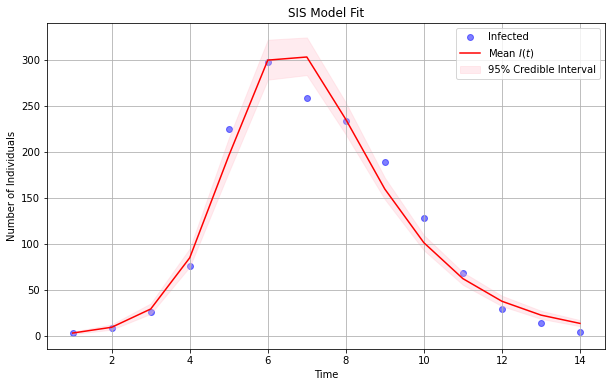

In [76]:
# Extract posterior samples
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples['z']

# Calculate median and credible intervals
lower_bound_infected = jnp.percentile(z_samples, 2.5, axis=0)[:, 1]
upper_bound_infected = jnp.percentile(z_samples, 97.5, axis=0)[:, 1]
mean_infected        = jnp.mean(z_samples, axis=0)[:, 1]

# Plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(data['t'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# Plot median of the posterior distribution
plt.plot(data['t'], mean_infected, color='red', label='Mean $I(t)$')

# Plot uncertainty bounds
plt.fill_between(data['t'], lower_bound_infected, upper_bound_infected, color='pink', alpha=0.3, label='95% Credible Interval')

plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('SIR Model Fit')
plt.legend()
plt.grid(True)
plt.show()

In fact, we can plot all three trajectories $S(t), I(t), R(t)$:

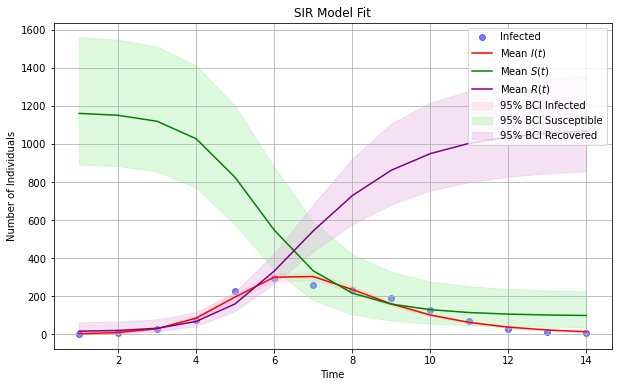

In [77]:
# Extract posterior samples
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples['z']

# Calculate median and credible intervals for each compartment
lower_bound_infected = jnp.percentile(z_samples, 2.5, axis=0)[:, 1]
upper_bound_infected = jnp.percentile(z_samples, 97.5, axis=0)[:, 1]
mean_infected = jnp.mean(z_samples, axis=0)[:, 1]

lower_bound_susceptible = jnp.percentile(z_samples, 2.5, axis=0)[:, 0]
upper_bound_susceptible = jnp.percentile(z_samples, 97.5, axis=0)[:, 0]
mean_susceptible = jnp.mean(z_samples, axis=0)[:, 0]


lower_bound_recovered = jnp.percentile(z_samples, 2.5, axis=0)[:, 2]
upper_bound_recovered = jnp.percentile(z_samples, 97.5, axis=0)[:, 2]
mean_recovered = jnp.mean(z_samples, axis=0)[:, 2]


# Plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(data['t'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# Plot median of the posterior distribution for each compartment
plt.plot(data['t'], mean_infected, color='red', label='Mean $I(t)$')
plt.plot(data['t'], mean_susceptible, color='green', label='Mean $S(t)$')
plt.plot(data['t'], mean_recovered, color='purple', label='Mean $R(t)$')

# Plot uncertainty bounds for each compartment
plt.fill_between(data['t'], lower_bound_infected, upper_bound_infected, color='pink', alpha=0.3, label='95% BCI Infected')
plt.fill_between(data['t'], lower_bound_susceptible, upper_bound_susceptible, color='lightgreen', alpha=0.3, label='95% BCI Susceptible')
plt.fill_between(data['t'], lower_bound_recovered, upper_bound_recovered, color='plum', alpha=0.3, label='95% BCI Recovered')

plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('SIR Model Fit')
plt.legend(loc=1)
plt.grid(True)
plt.show()


Now the model output matches disease data pretty closely. The mode is doing a very good job, given how simple it is!

The SIR model is the prototypical infectious disease model because it can capture the overall shape of an outbreak.

Still, it relies on a series of assumptions:

- individuals are immediately infectious after an infection event,
- the mixing is homogeneous, 
- everyone in the same compartment is the same, i.e. individuals are indistinguishable.

An extension example:


## The basic reproduction number $R_0$.

```{margin}
Note that the assumtion of "an entirely susceptible population" is not realistic. Instead, one can study $R_t$.
$R_t$ is the number of cases of disease arising from an existing case at time $t$.
```
$R_0$ is a crucial number that policmakers talk a lot about. It is defined as the number of cases of disease arising from each primary case (in an entirely susceptible population).

From the SIR model, we can calculate $R_0$ as

$$
R_0 = \beta N / \mu.
$$

Nite that $1/\mu$ can be interpreted as time that it takes an individual to recover, i.e. how long an infectious individual is infectious for.

Diseases with different $R_0$ generate very different shapes.

Control measures usually aim to bring $R_0$ to be under 1.

## Herd immmunity

Herd immuninty is resistance to the spread of a disease that results if a sufficiently high proportion of individuals are immune.


